<a href="https://colab.research.google.com/github/zehrahayirci/instagram_t-SNE/blob/master/insta_t_SNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hello! In this Colab, we mplement t-SNE algorithm for color histagram and ImageNet classes of Instagram posts. This works best in Google Colab




In [0]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import glob
import pickle
from sklearn.manifold import TSNE
from scipy.spatial.distance import cdist

First, we download photos from instagram by [instaloader](https://pypi.org/project/instaloader/)



---



In [2]:
!pip install instaloader
profilename = 'tokyoda100gun' #that's me!

  Created wheel for instaloader: filename=instaloader-4.2.8-cp36-none-any.whl size=40667 sha256=c20042cc14484cd5bc395270b6b3280f538656c42f63293c0080bc0f5779718b
  Stored in directory: /root/.cache/pip/wheels/43/da/98/3e3105f88188f563769f69d20d4444080716097b57fb118964
Successfully built instaloader


We will get all photos of one user with
`instaloader profile [profile ...]`

Keep in mind that, this colab works best for 100+ posts to create 10x10 grid image



In [3]:
!instaloader profile $profilename

Stored ID 725407287 for profile profile.
Stored ID 8716249509 for profile tokyoda100gun.
tokyoda100gun/2019-04-07_15-16-51_UTC_profile_pic.jpg 
Retrieving posts from profile tokyoda100gun.
[  1/300] tokyoda100gun/2019-07-30_19-42-18_UTC.jpg [toykoda300renk #tokyo] json 
[  2/300] tokyoda100gun/2019-07-27_19-27-40_UTC.jpg [Munih'te 22.ay donumumu #neus…] json 
[  3/300] tokyoda100gun/2019-07-24_16-54-50_UTC.jpg [Çok sıcak çok sıcak çok sıcak…] json 
[  4/300] tokyoda100gun/2019-07-21_10-10-28_UTC.jpg [🥁] json 
[  5/300] tokyoda100gun/2019-07-20_21-58-06_UTC.jpg [🎆🎇✨ #munich #münchen #olympia…] tokyoda100gun/2019-07-20_21-58-06_UTC.mp4 json 
[  6/300] tokyoda100gun/2019-07-16_19-51-55_UTC_1.jpg tokyoda100gun/2019-07-16_19-51-55_UTC_2.jpg tokyoda100gun/2019-07-16_19-51-55_UTC_3.jpg tokyoda100gun/2019-07-16_19-51-55_UTC_4.jpg tokyoda100gun/2019-07-16_19-51-55_UTC_5.jpg [Bu kafe de çizgi filmlere tat…] json 
[  7/300] tokyoda100gun/2019-07-15_16-08-53_UTC.jpg [*Aslında hasta yatıyor* #toky…

If your profile is more than 100, or you want to add/discard manually you can use the Files bar on the left and locate your profile name. 
I want to use resized images. 


In [0]:

instagram_files = "/content/" + profilename + "/*.jpg"
resize_files = "/content/" + profilename +"/"
for f,insta_file in enumerate(glob.glob(instagram_files)):
    image = Image.open(insta_file)
    resized_img =  image.resize((100,100), Image.ANTIALIAS)

    #resized_img = Image.fromarray(resized_img)
    outfile = resize_files + insta_file

    resized_img.save(resize_files+str(f)+'.png', 'png', quality=80)
    if f > 98:
      break
    


First, we create histograms of the posts. Sorry for all b&w posts!

In [0]:
resize_files = "/content/" + profilename +"/*.png"
color = ('b','g','r')
files = [resize_files]
hist_data = {}
index = 0 
for filem in files:
	hist_data[filem]={}
	for filename in glob.glob(filem):
		hist_data[filem][filename]={}

		for i,col in enumerate(color):
			im=Image.open(filename)
			image_data = np.asarray(im)
			if len(image_data.shape) == 2 :
				image_data = cv.cvtColor(image_data,cv.COLOR_GRAY2RGB)
			index = index +1
			hist_data[filem][filename][col] = cv.calcHist([image_data],[i],None,[256],[0,256])



Create a list of all histogram of all images. 
I set perplexity to 25, but you can play it as you want

In [0]:

hist = np.zeros((100,768))
filenames = []
for fil, filem in enumerate(hist_data): #1
	for fn,filename in enumerate(hist_data[filem]): 
		hist[fn,0:256] = hist_data[filem][filename]['b'][:,0] #256
		hist[fn,256:512] = hist_data[filem][filename]['g'][:,0] #256
		hist[fn,512:768] = hist_data[filem][filename]['r'][:,0] #256
		filenames.append((filem,filename))

		
tsne = TSNE(perplexity=25, n_components=2, init='random', n_iter=5000)
X_2d = tsne.fit_transform(np.array(hist))
X_2d -= X_2d.min(axis=0)
X_2d /= X_2d.max(axis=0)


We need lapjv to create a nice grid from t-SNE results

In [7]:
!pip install lapjv
from lapjv import lapjv

  Created wheel for lapjv: filename=lapjv-1.3.1-cp36-cp36m-linux_x86_64.whl size=83701 sha256=d14253aa49b67a4d7815bba38140ee9fac2e1f17a07620d95acfffbd32b4e5e0
  Stored in directory: /root/.cache/pip/wheels/6e/fe/fd/b700bd67e00bcd65241d55d875eec17892a86ca6a4deef9515
Successfully built lapjv


In [0]:
grid = np.dstack(np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))).reshape(-1, 2)
cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
out_res = 120

In [0]:
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
row_asses, col_asses, _ = lapjv(cost_matrix)
grid_jv = grid[col_asses]

In [0]:
out = np.ones((10*out_res, 10*out_res, 3))

for i in range(100):
	coordinate_X =  int(np.floor(grid_jv[i,1]*9*out_res))
	coordinate_Y =  int(np.floor(grid_jv[i,0]*9*out_res))

	im=Image.open(filenames[i][1]).convert('RGB').resize((120,120))
	image_data = np.asarray(im)
	out[coordinate_Y:coordinate_Y + out_res, coordinate_X:coordinate_X + out_res]  = image_data


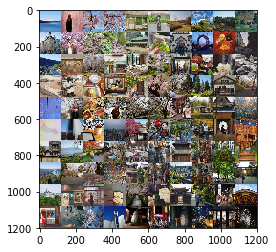

In [11]:
im = Image.fromarray(out.astype(np.uint8))
im.save("insta_histogram.png")
plt.imshow(im)

Perfect! now, we can continue to ImageNet classes and create another feature.

I use Resnet for it 

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
resnet18.eval()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 64707173.52it/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

I don't want to results for Imagenet, instead, I will use the last features.

I discard the last activation step from the network and rename the result as resnet18_feature

Please enable GPU from Edit -> Notebook Settings -> Hardware

In [0]:
import torch.nn as nn
modus=list(resnet18.children())[:-1]
resnet18_feature=nn.Sequential(*modus)
resnet18_feature.cuda()
for p in resnet18_feature.parameters():
  p.requires_grad = False

In [0]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [0]:

files = [resize_files]
features = {}

for filem in files:
  for img in  glob.glob(filem):
    insta_image = Image.open(img)
    img_t = transform(insta_image)
    batch_t = torch.unsqueeze(img_t, 0)
    out_feature = resnet18_feature(batch_t.cuda())
    out_feature = out_feature.view(512)
    features[img] = out_feature.cpu().detach().numpy().reshape(512)

    



Now we have all feature in the pickle file, we can visualize them just like histogram.

In [0]:
feat = np.zeros((100,512))

for fn,filename in enumerate(features):
   feat[fn]=features[filename]


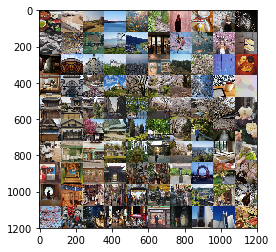

In [18]:

tsne = TSNE(perplexity=25, n_components=2, init='random', n_iter=5000)
X_2d = tsne.fit_transform(np.array(feat))
X_2d -= X_2d.min(axis=0)
X_2d /= X_2d.max(axis=0)


grid = np.dstack(np.meshgrid(np.linspace(0, 1, 10), np.linspace(0, 1, 10))).reshape(-1, 2)
cost_matrix = cdist(grid, X_2d, "sqeuclidean").astype(np.float32)
out_res = 120
   
cost_matrix = cost_matrix * (100000 / cost_matrix.max())
row_asses, col_asses, _ = lapjv(cost_matrix)
grid_jv = grid[col_asses]

out = np.ones((10*out_res, 10*out_res, 3))

for i in range(100):
	coordinate_X =  int(np.floor(grid_jv[i,1]*9*out_res))
	coordinate_Y =  int(np.floor(grid_jv[i,0]*9*out_res))

	im=Image.open(filenames[i][1]).convert('RGB').resize((120,120))
	image_data = np.asarray(im)
	out[coordinate_Y:coordinate_Y + out_res, coordinate_X:coordinate_X + out_res]  = image_data
im = Image.fromarray(out.astype(np.uint8))
im.save("tsne_features.png")
plt.imshow(im)